<a href="https://colab.research.google.com/github/saishshinde15/NLP/blob/main/Name_Entity_Rec_Guided.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle

In [2]:
# conll 2003
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_test.pkl

--2024-05-03 13:08:38--  https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4757208 (4.5M) [application/octet-stream]
Saving to: ‘ner_train.pkl’

ner_train.pkl       100%[===================>]   4.54M  --.-KB/s    in 0.1s    

2024-05-03 13:08:38 (47.3 MB/s) - ‘ner_train.pkl’ saved [4757208/4757208]

--2024-05-03 13:08:39--  https://lazyprogrammer.me/course_files/nlp/ner_test.pkl
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1201978 (1.1M) [application/octet-stream]
Saving to: ‘ner_test.pkl’

ner_test.pkl        100%[===========

In [3]:
with open('ner_train.pkl', 'rb') as f:
  corpus_train = pickle.load(f)

with open('ner_test.pkl', 'rb') as f:
  corpus_test = pickle.load(f)

In [4]:
train_inputs = []
train_targets = []

for sentence_tag_pairs in corpus_train:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  train_inputs.append(tokens)
  train_targets.append(target)

In [5]:
test_inputs = []
test_targets = []

for sentence_tag_pairs in corpus_test:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  test_inputs.append(tokens)
  test_targets.append(target)

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [7]:
# Convert sentences to sequences

MAX_VOCAB_SIZE = None

# capitalization might be useful - test it
should_lowercase = False
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=should_lowercase,
    oov_token='UNK',
)
# otherwise unknown tokens will be removed and len(input) != len(target)
# input words and target words will not be aligned!

# it's ok to "fit" on the whole corpus - it just means some embeddings
# won't be trained
# this is because for the test set, any unknown tokens will be removed
# which will change the length of the input (***CHECK)

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)


In [8]:
# get word -> integer mapping
word2idx = word_tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)


Found 23299 unique tokens.


In [9]:
# https://stackoverflow.com/questions/11264684/flatten-list-of-lists
def flatten(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [10]:
all_train_targets = set(flatten(train_targets))
all_train_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [11]:
all_test_targets = set(flatten(test_targets))
all_test_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [12]:
all_train_targets == all_test_targets

True

In [13]:
# Convert targets to sequences
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

# save for later
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [14]:
# before padding, find max document length
# because we don't want to truncate any inputs
# which would also truncate targets
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max((maxlen_train, maxlen_test))

In [15]:
# pad sequences so that we get a N x T matrix
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

Shape of data train tensor: (12733, 113)


In [16]:
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

Shape of data test tensor: (2970, 113)


In [17]:
train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print('Shape of train targets tensor:', train_targets_int.shape)


Shape of train targets tensor: (12733, 113)


In [18]:
# number of classes
K = len(tag_tokenizer.word_index) + 1
K

10

In [19]:
# Create the model

# We get to choose embedding dimensionality
D = 32

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
# mask_zero=True way slower on GPU than CPU!
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
# x = SimpleRNN(32, return_sequences=True)(x)
x = Dense(K)(x)

model = Model(i, x)

In [22]:
# prompt: compile and fit

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'],
)
r = model.fit(
    train_inputs_int, train_targets_int,
    batch_size=32,
    epochs=5,
    validation_split=0.1,
)


Epoch 1/5
359/359 [==============================] - 119s 302ms/step - loss: 0.1221 - accuracy: 0.9684 - val_loss: 0.0902 - val_accuracy: 0.9767
Epoch 2/5
359/359 [==============================] - 105s 292ms/step - loss: 0.0638 - accuracy: 0.9852 - val_loss: 0.0797 - val_accuracy: 0.9786
Epoch 3/5
359/359 [==============================] - 104s 290ms/step - loss: 0.0367 - accuracy: 0.9916 - val_loss: 0.0772 - val_accuracy: 0.9792
Epoch 4/5
359/359 [==============================] - 109s 304ms/step - loss: 0.0239 - accuracy: 0.9947 - val_loss: 0.0835 - val_accuracy: 0.9779
Epoch 5/5
359/359 [==============================] - 109s 305ms/step - loss: 0.0163 - accuracy: 0.9962 - val_loss: 0.0846 - val_accuracy: 0.9773


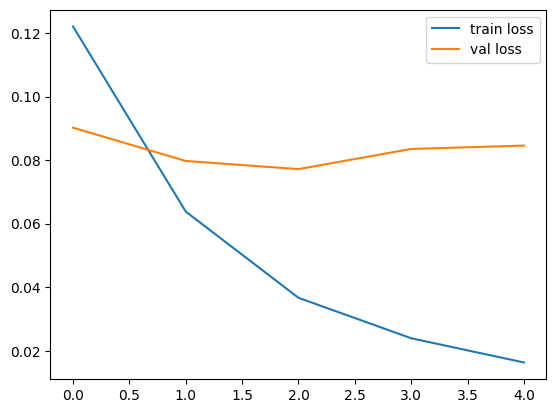

In [23]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

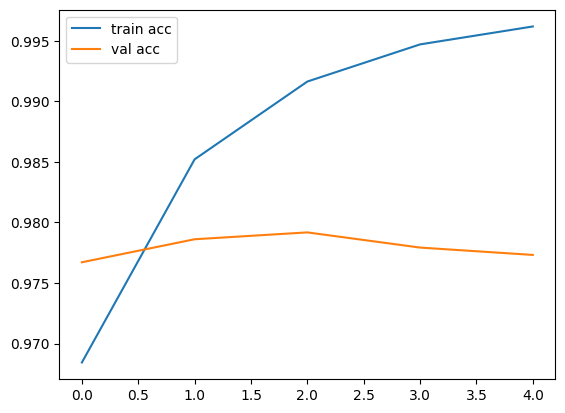

In [24]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [25]:
# True model accuracy - above includes padding

# first get length of each sequence
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))

test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))


In [26]:
train_probs = model.predict(train_inputs_int) # N x T x K
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  train_predictions.append(preds)

# flatten
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)


398/398 [==============================] - 38s 86ms/step


In [27]:
test_probs = model.predict(test_inputs_int) # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)

# flatten
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)

93/93 [==============================] - 7s 72ms/step


In [28]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.9951934547478924
Test acc: 0.9538933821358994
Train f1: 0.9700369166236857
Test f1: 0.8089994526686639


In [29]:
### Baseline model: map word to tag
from collections import Counter

# https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
def most_common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

In [30]:
token2tags = {k: [] for k, v in word2idx.items()}

# remove UNK token
del token2tags['UNK']

for tokens, tags in zip(train_inputs, train_targets):
  for token, tag in zip(tokens, tags):
    if should_lowercase:
      token = token.lower()
    if token in token2tags:
      token2tags[token].append(tag)

for k, v in token2tags.items():
  if len(v) == 0:
    print(k)

token2tag = {k: most_common(v) for k, v in token2tags.items()}

In [31]:
# compute accuracy

train_predictions = []
for sentence in train_inputs:
  predictions = []
  for token in sentence:
    if should_lowercase:
      token = token.lower()
    predicted_tag = token2tag[token]
    predictions.append(predicted_tag)
  train_predictions.append(predictions)
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets)

In [32]:
test_predictions = []
for sentence in test_inputs:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag.get(token, 'INCORRECT')
    predictions.append(predicted_tag)
  test_predictions.append(predictions)
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets)


In [33]:
print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))


Train acc: 0.974769365357086
Test acc: 0.8881673455733318
Train f1: 0.8549353965547479
Test f1: 0.6381158268902334
